In [1]:
# Práctica 6: Inferencia de parámetros en Modelos ARIMA
# Serie de Tiempo: Temperaturas promedio mensuales (2000-2023)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
# 1. Dataset sintético
np.random.seed(42)
periods = 24*12  # 24 años de datos mensuales
trend = np.linspace(20, 22, periods)  # Tendencia leve creciente
temp_series = trend + np.sin(np.linspace(0, 12*np.pi, periods)) + np.random.normal(0, 0.5, periods)

fechas = pd.date_range(start='2000-01-01', periods=periods, freq='M')
df = pd.DataFrame({'Fecha': fechas, 'Temperatura': temp_series})
df.set_index('Fecha', inplace=True)

<ipython-input-2-17d9a6928947>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas = pd.date_range(start='2000-01-01', periods=periods, freq='M')


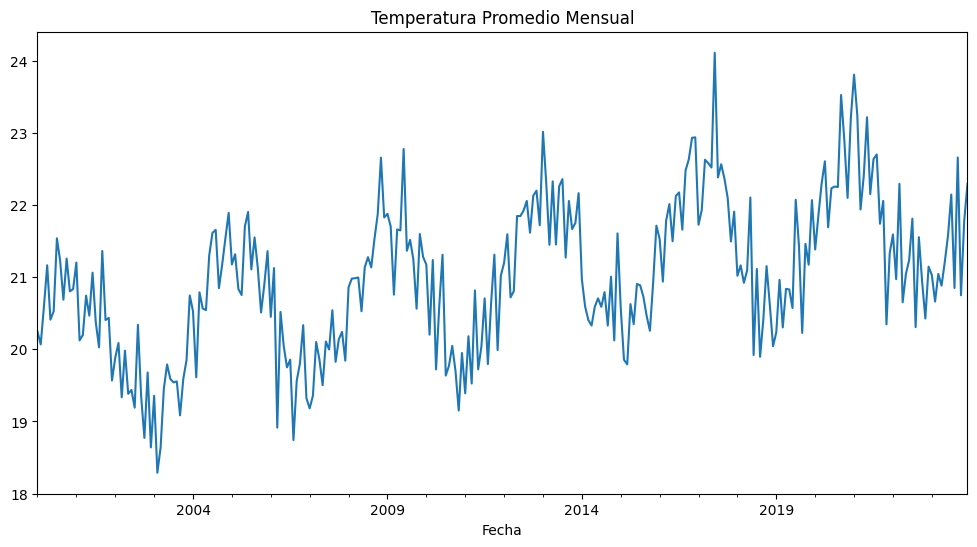

In [3]:
# 2. Visualizar la Serie
df['Temperatura'].plot(figsize=(12,6), title='Temperatura Promedio Mensual')
plt.show()

In [4]:
# 3. Comprobación de estacionariedad (Prueba ADF)
resultado_adf = adfuller(df['Temperatura'])
print('Estadístico ADF:', resultado_adf[0])
print('p-valor:', resultado_adf[1])

# Si p-valor > 0.05, no es estacionaria. Diferenciamos.
df_diff = df['Temperatura'].diff().dropna()

# Verificamos de nuevo
resultado_adf_diff = adfuller(df_diff)
print('\nDespues de diferenciar:')
print('Estadístico ADF:', resultado_adf_diff[0])
print('p-valor:', resultado_adf_diff[1])

Estadístico ADF: -4.35770144498591
p-valor: 0.0003523965560266421

Despues de diferenciar:
Estadístico ADF: -4.375004894055169
p-valor: 0.0003285707101327346


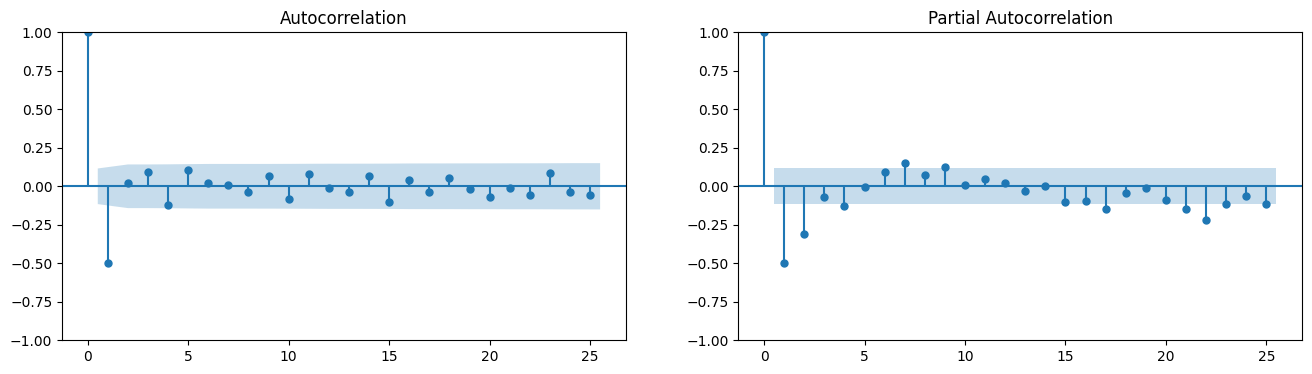

In [5]:
# 4. Identificación de p y q (ACF y PACF)
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1], method='ywm')
plt.show()

# Basado en los gráficos, proponemos valores iniciales
# p = 1, d = 1, q = 1 (puede ajustarse)

In [6]:
# 5. Ajuste del modelo ARIMA
modelo = ARIMA(df['Temperatura'], order=(1,1,1))
modelo_fit = modelo.fit()
print(modelo_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Temperatura   No. Observations:                  288
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -264.305
Date:                Sun, 27 Apr 2025   AIC                            534.610
Time:                        06:35:32   BIC                            545.588
Sample:                    01-31-2000   HQIC                           539.010
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1826      0.097     -1.876      0.061      -0.373       0.008
ma.L1         -0.4986      0.086     -5.795      0.000      -0.667      -0.330
sigma2         0.3687      0.032     11.394      0.0

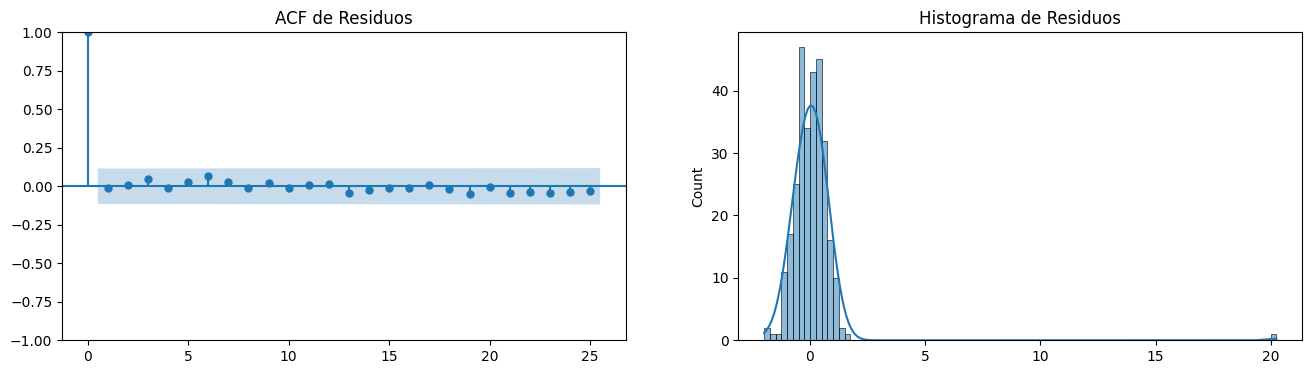

Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  2.786606   0.986009


In [7]:
# 6. Diagnóstico de residuos
residuos = modelo_fit.resid
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(residuos, ax=axes[0])
sns.histplot(residuos, kde=True, ax=axes[1])
axes[0].set_title('ACF de Residuos')
axes[1].set_title('Histograma de Residuos')
plt.show()

# Prueba de Ljung-Box
print('Prueba de Ljung-Box:')
print(acorr_ljungbox(residuos, lags=[10], return_df=True))

<ipython-input-8-74d97ae46c07>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1]+pd.Timedelta(days=30), periods=12, freq='M'), forecast, label='Pronóstico', color='red')


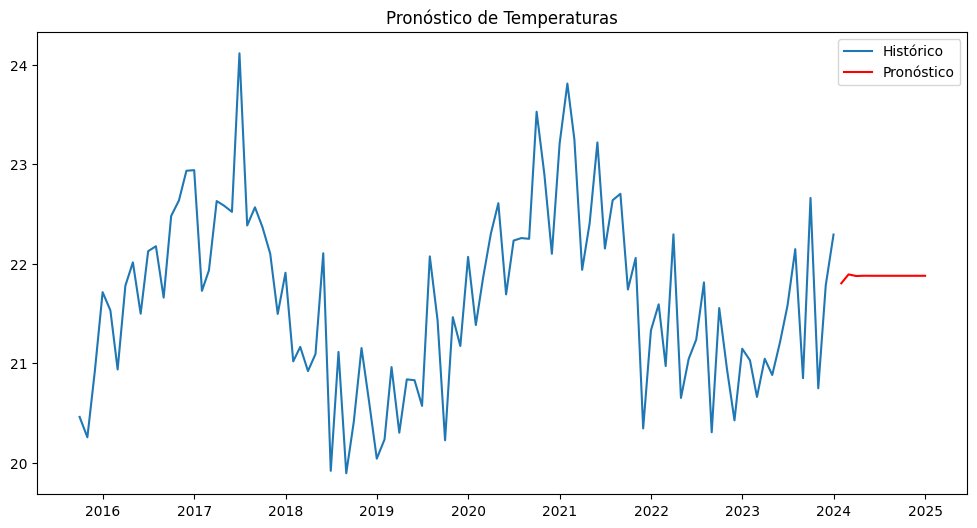

In [8]:
# 7. Pronóstico
forecast = modelo_fit.forecast(steps=12)

# Visualizar pronóstico
plt.figure(figsize=(12,6))
plt.plot(df.index[-100:], df['Temperatura'][-100:], label='Histórico')
plt.plot(pd.date_range(df.index[-1]+pd.Timedelta(days=30), periods=12, freq='M'), forecast, label='Pronóstico', color='red')
plt.title('Pronóstico de Temperaturas')
plt.legend()
plt.show()